# Data Journalism/Sports and Data: Tennis WTA

Small project example treating historical data of the Women Tennis Association based on the following:

- Source: https://github.com/JeffSackmann/tennis_wta
- Examples: https://github.com/JeffSackmann/tennis_atp/tree/master/examples

**Author**: routarddev

**Github**: https://github.com/routarddev

In [3]:
from pymongo import MongoClient
import pprint

# Connect to mongo client and list databases
client = MongoClient()
client.list_database_names()

['admin',
 'config',
 'local',
 'players',
 'popcorn',
 'relief_crisis_project',
 'surveys',
 'tennis_wta',
 'test',
 'tfm']

In [4]:
# We expect the database 'tennis_wta' to exist and to have three collections
db = client.tennis_wta
db.list_collection_names()

['wta_rankings',
 'wta_matches',
 'wta_players',
 'wta_rankings_year',
 'wta_matches_year']

In [3]:
# Collections are currenlty empty
db.wta_matches.count_documents({})

0

In [4]:
db.wta_rankings.count_documents({})

0

In [5]:
db.wta_players.count_documents({})

0

In [6]:
# Get current working directory. 
# Should be the one where where the project, that is, this jupyter notebook and code is.
import os

os.getcwd()

'/home/hadrien/development/KnowledgeManagement/project/tennis_wta'

In [7]:
# List files in the current directory
os.listdir()

['tennis_wta-master.zip',
 'Sports - Tennis-Copy2.ipynb',
 'Sports - Tennis-backup.ipynb',
 'Sports - Tennis-Copy1.ipynb',
 '.ipynb_checkpoints',
 'files',
 'Sports - Tennis.ipynb']

In [8]:
# Go to the directory were the raw data files are and load them into the mongo database
# We start creating and filling 3 collections: wta_players, wta_matches and wta_rankings

import os
import re

os.chdir(os.getcwd() + '/files/')
os.getcwd()

pattern_matches = re.compile("wta_matches_[0-9]+")
#pattern_rankings = re.compile("wta_rankings_[0-9]+")
pattern_rankings = "wta_rankings"
pattern_players = "wta_players"

# Function to import file data depending on the collection and file name
def mongo_import(collection, file):
    command = 'mongoimport --db tennis_wta --collection '+collection +' --mode=upsert --type csv --file '+file +' --headerline'
    os.system(command)

for f in os.listdir():
    if pattern_matches.match(f):
        mongo_import('wta_matches', f)
    #elif pattern_rankings.match(f):
    elif f.startswith(pattern_rankings):
        mongo_import(pattern_rankings, f)
    elif f.startswith(pattern_players):
        mongo_import(pattern_players, f)

In [9]:
# Check that the collections have been filled with the files data
db.wta_matches.count_documents({})

111598

In [10]:
# Number of documents in wta_rankings collection
db.wta_rankings.count_documents({})

1670401

In [11]:
# Number of documents in wta_players collection
db.wta_players.count_documents({})

21751

In [12]:
# Show wta_players collection structure
db.wta_players.find_one()

{'_id': ObjectId('5cc797bc539d8bb447a320d3'),
 'player_id': 200000,
 'first_name': 'X',
 'last_name': 'X',
 'hand': 'U',
 'birth_date': 19000000,
 'country_code': 'UNK'}

In [13]:
# Show wta_rankings collection structure
db.wta_rankings.find_one()

{'_id': ObjectId('5cc795c2539d8bb4476cfa6b'),
 'ranking_date': 20180101,
 'ranking': 1,
 'player_id': 201594,
 'ranking_points': 6175,
 'field4': 18}

In [14]:
# Show wta_matches collection structure. This is the most complex document, with several fields of information
db.wta_matches.find_one()

{'_id': ObjectId('5cc795c2539d8bb4476ce49c'),
 'tourney_id': '2008-W-SL-AUS-01A-2008',
 'tourney_name': 'Australian Open',
 'surface': 'Hard',
 'draw_size': 128,
 'tourney_level': 'G',
 'tourney_date': 20080114,
 'match_num': 1,
 'winner_id': 200003,
 'winner_seed': 1,
 'winner_entry': '',
 'winner_name': 'Justine Henin',
 'winner_hand': 'R',
 'winner_ht': 167,
 'winner_ioc': 'BEL',
 'winner_age': 25.620807666,
 'winner_rank': 1,
 'winner_rank_points': 6430,
 'loser_id': 201411,
 'loser_seed': '',
 'loser_entry': '',
 'loser_name': 'Aiko Nakamura',
 'loser_hand': 'R',
 'loser_ht': 163,
 'loser_ioc': 'JPN',
 'loser_age': 24.0465434634,
 'loser_rank': 73,
 'loser_rank_points': 424,
 'score': '6-2 6-2',
 'best_of': 3,
 'round': 'R128',
 'minutes': '',
 'w_ace': 7,
 'w_df': 6,
 'w_svpt': 61,
 'w_1stIn': 33,
 'w_1stWon': 22,
 'w_2ndWon': 12,
 'w_SvGms': '',
 'w_bpSaved': 4,
 'w_bpFaced': 6,
 'l_ace': 0,
 'l_df': 2,
 'l_svpt': 66,
 'l_1stIn': 47,
 'l_1stWon': 25,
 'l_2ndWon': 4,
 'l_SvGms': 

In [15]:
# Add the new field 'year' using the tourney_id indicator

# The following operation just does a projection, that is,
#   we are missing the other values, the ones non-specified
#   in the operation
'''
db.wta_matches.aggregate(
  [
    {
      '$project': {
          "tourney_id": 1,
          "year": { '$substrCP': [ "$tourney_id", 0, 4 ] }
      }
    },
    { '$out': "wta_matches_year"}
  ]
)
'''

# Not working, neither what we want
''' 
db.wta_matches.update_many(
    {},
    { '$set': {'year' : { '$substrCP': [ "$tourney_id", 0, 4 ] } }}
)
'''

# Add the new field 'year' using the tourney_id indicator
db.wta_matches.aggregate( [
    {
        '$addFields': {
            'year': { '$substrCP': [ "$tourney_id", 0, 4 ] }
        }
    },
    { '$out': "wta_matches_year"}
])

In [16]:
# Delete new created field if not what expected
# Just for safety reasons, execute wisely
'''
db.wta_matches.update_many(
    {},
    {'$unset': {'year': 1}}
)
'''

"\ndb.wta_matches.update_many(\n    {},\n    {'$unset': {'year': 1}}\n)\n"

In [17]:
# Check that we obtained the new collection with the new field
pprint.pprint(db.wta_matches_year.find_one())

{'_id': ObjectId('5cc795c2539d8bb4476ce49c'),
 'best_of': 3,
 'draw_size': 128,
 'l_1stIn': 47,
 'l_1stWon': 25,
 'l_2ndWon': 4,
 'l_SvGms': '',
 'l_ace': 0,
 'l_bpFaced': 15,
 'l_bpSaved': 9,
 'l_df': 2,
 'l_svpt': 66,
 'loser_age': 24.0465434634,
 'loser_entry': '',
 'loser_hand': 'R',
 'loser_ht': 163,
 'loser_id': 201411,
 'loser_ioc': 'JPN',
 'loser_name': 'Aiko Nakamura',
 'loser_rank': 73,
 'loser_rank_points': 424,
 'loser_seed': '',
 'match_num': 1,
 'minutes': '',
 'round': 'R128',
 'score': '6-2 6-2',
 'surface': 'Hard',
 'tourney_date': 20080114,
 'tourney_id': '2008-W-SL-AUS-01A-2008',
 'tourney_level': 'G',
 'tourney_name': 'Australian Open',
 'w_1stIn': 33,
 'w_1stWon': 22,
 'w_2ndWon': 12,
 'w_SvGms': '',
 'w_ace': 7,
 'w_bpFaced': 6,
 'w_bpSaved': 4,
 'w_df': 6,
 'w_svpt': 61,
 'winner_age': 25.620807666,
 'winner_entry': '',
 'winner_hand': 'R',
 'winner_ht': 167,
 'winner_id': 200003,
 'winner_ioc': 'BEL',
 'winner_name': 'Justine Henin',
 'winner_rank': 1,
 'winner_

In [18]:
db.wta_rankings.distinct('ranking_date')

[20180101,
 20180108,
 20180115,
 20180129,
 20180205,
 20180212,
 20180219,
 20180226,
 20180305,
 20180319,
 20180402,
 20180409,
 20180416,
 20180423,
 20180430,
 20180507,
 20180514,
 20180521,
 20180528,
 20180611,
 20180618,
 20180625,
 20180702,
 20180716,
 20180723,
 20180730,
 20180806,
 20180813,
 20180820,
 20180827,
 20180910,
 20180917,
 20180924,
 20181001,
 20181008,
 20181015,
 20181022,
 20181029,
 20181105,
 20181112,
 20181119,
 20181126,
 20181203,
 20181210,
 20181217,
 20181224,
 20181231,
 20000101,
 20000103,
 20000110,
 20000117,
 20000124,
 20000131,
 20000207,
 20000214,
 20000221,
 20000228,
 20000306,
 20000313,
 20000320,
 20000327,
 20000403,
 20000410,
 20000417,
 20000424,
 20000501,
 20000508,
 20000515,
 20000522,
 20000529,
 20000605,
 20000612,
 20000619,
 20000626,
 20000703,
 20000710,
 20000717,
 20000724,
 20000731,
 20000807,
 20000814,
 20000821,
 20000828,
 20000904,
 20000911,
 20000918,
 20000925,
 20001002,
 20001009,
 20001016,
 20001023,

In [19]:
# Add the new field 'year' to the wta_rankings collection using the ranking_data indicator
db.wta_rankings.aggregate([
    {
        '$addFields': {
            'year': { '$substrCP': [ "$ranking_date", 0, 4 ] }
        }
    },
    { '$out': "wta_rankings_year"}
])

In [20]:
# Check that we obtained the new collection with the new field
db.wta_rankings_year.find_one()

{'_id': ObjectId('5cc795c2539d8bb4476cfa6b'),
 'ranking_date': 20180101,
 'ranking': 1,
 'player_id': 201594,
 'ranking_points': 6175,
 'field4': 18,
 'year': '2018'}

In [5]:
# Use pandas to work with data
import pandas as pd

players_data = list(db.wta_players.find())
players_df = pd.DataFrame(players_data)
players_df.head()

,_id,birth_date,country_code,first_name,hand,last_name,player_id
0,5cc797bc539d8bb447a320d3,19000000,UNK,X,U,X,200000
1,5cc797bc539d8bb447a320d5,19800930,SUI,Martina,R,Hingis,200001
2,5cc797bc539d8bb447a320d7,19820309,CRO,Mirjana,R,Lucic,200002
3,5cc797bc539d8bb447a320d9,19820601,BEL,Justine,R,Henin,200003
4,5cc797bc539d8bb447a320db,19721204,AUS,Kerry Anne,R,Guse,200004


In [22]:
# Return number of rows and columns in the players data frame
players_df.shape

(21751, 7)

In [6]:
rankings_data = list(db.wta_rankings_year.find())
rankings_df = pd.DataFrame(rankings_data)
rankings_df.head()

,_id,field4,player_id,ranking,ranking_date,ranking_points,year
0,5cc795c2539d8bb4476cfa6b,18,201594,1,20180101,6175,2018
1,5cc795c2539d8bb4476cfa6d,21,202469,2,20180101,6135,2018
2,5cc795c2539d8bb4476cfa6f,23,201496,3,20180101,6015,2018
3,5cc795c2539d8bb4476cfa71,20,201662,4,20180101,5730,2018
4,5cc795c2539d8bb4476cfa73,16,200748,5,20180101,5597,2018


In [24]:
# Return number of rows and columns in the rankings data frame
rankings_df.shape

(1670401, 7)

In [8]:
matches_data = list(db.wta_matches_year.find())
matches_df = pd.DataFrame(matches_data)
matches_df.head()

,_id,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,...,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed,year
0,5cc795c2539d8bb4476ce49c,3,128,47,25,4,,0,15,9,...,,R,167,200003,BEL,Justine Henin,1,6430,1,2008
1,5cc795c2539d8bb4476ce49e,3,128,25,8,5,,1,9,2,...,,U,,201479,RUS,Olga Puchkova,97,353,,2008
2,5cc795c2539d8bb4476ce4a0,3,128,53,28,12,,1,10,5,...,,L,173,201493,GER,Angelique Kerber,89,378,,2008
3,5cc795c2539d8bb4476ce4a2,3,128,46,30,5,,2,5,2,...,,R,166,201212,ITA,Francesca Schiavone,24,1101,25,2008
4,5cc795c2539d8bb4476ce4a4,3,128,69,35,21,,0,13,6,...,,L,174,201446,AUT,Sybille Bammer,20,1308,19,2008


In [26]:
# Return number of rows and columns in the matches data frame
matches_df.shape

(111598, 51)

### Mapping and plotting resources:

- http://ramiro.org/notebook/geopandas-choropleth/
- http://ramiro.org/notebook/basemap-choropleth/
- http://geopandas.org/mapping.html
- https://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434
- https://github.com/pysal/mapclassify
- https://plot.ly/python/

In [27]:
#data = data.dropna()
players_by_country = pd.DataFrame()
#players_by_country['country_code'] = players_df.country_code.unique()
players_by_country['total'] = players_df.groupby('country_code')['player_id'].count()

'''
for country_code in players_df.country_code.unique():
    print(country_code)
#    players_by_country[str(country_code)]['total'] = players_df.country_code.value_counts()[country_code]
    players_by_country[country_code]['total'] = players_df['country_code'].value_counts()
'''
players_by_country = players_by_country.dropna()
players_by_country

,total
country_code,
,17
AHO,6
ALB,2
ALG,64
AND,1
ANG,1
ANT,8
ARG,484
ARM,28


In [28]:
# Clean values from ISO codes
players_by_country = players_by_country.drop(['','rc='])
players_by_country.head(20)

,total
country_code,
AHO,6
ALB,2
ALG,64
AND,1
ANG,1
ANT,8
ARG,484
ARM,28
AUS,760


In [29]:
# Move country codes index data as a column
players_by_country = players_by_country.reset_index()
players_by_country

,country_code,total
0,AHO,6
1,ALB,2
2,ALG,64
3,AND,1
4,ANG,1
5,ANT,8
6,ARG,484
7,ARM,28
8,AUS,760
9,AUT,248


In [30]:
# Plot map with matches and players per country
import matplotlib.pyplot as plt
#import sys
#!{sys.executable} -m pip install descartes
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install mapclassify
import geopandas as gpd

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


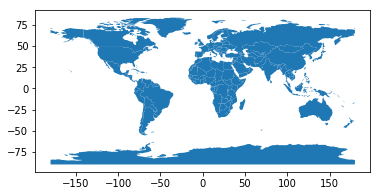

In [32]:
world.plot()

In [33]:
merged = world.merge(players_by_country, left_on='iso_a3', right_on="country_code" )
merged.describe()

,pop_est,gdp_md_est,total
count,7.900000e+01,7.900000e+01,79.000000
mean,6.605414e+07,1.153084e+06,207.759494
std,2.121849e+08,3.302545e+06,339.226806
min,3.397470e+05,7.892000e+03,1.000000
25%,4.968716e+06,4.305000e+04,18.000000
50%,1.113823e+07,1.747000e+05,78.000000
75%,4.161299e+07,6.423500e+05,260.500000
max,1.379303e+09,2.114000e+07,2333.000000


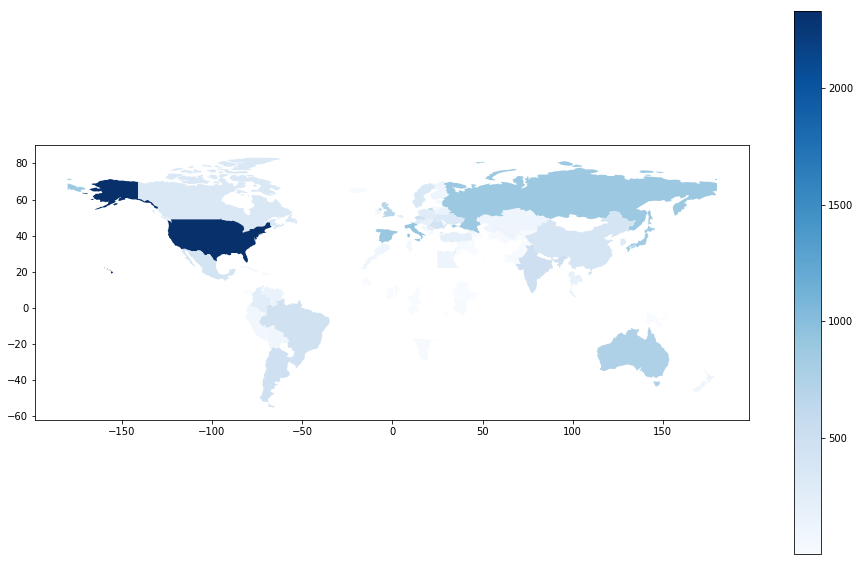

In [34]:
ax = merged.dropna().plot(
    column='total', 
    cmap='Blues', 
    figsize=(16, 10),
    #scheme='natural_breaks',
    k=['total'],
    legend=True
)

Text(0,0.5,'Country Code')

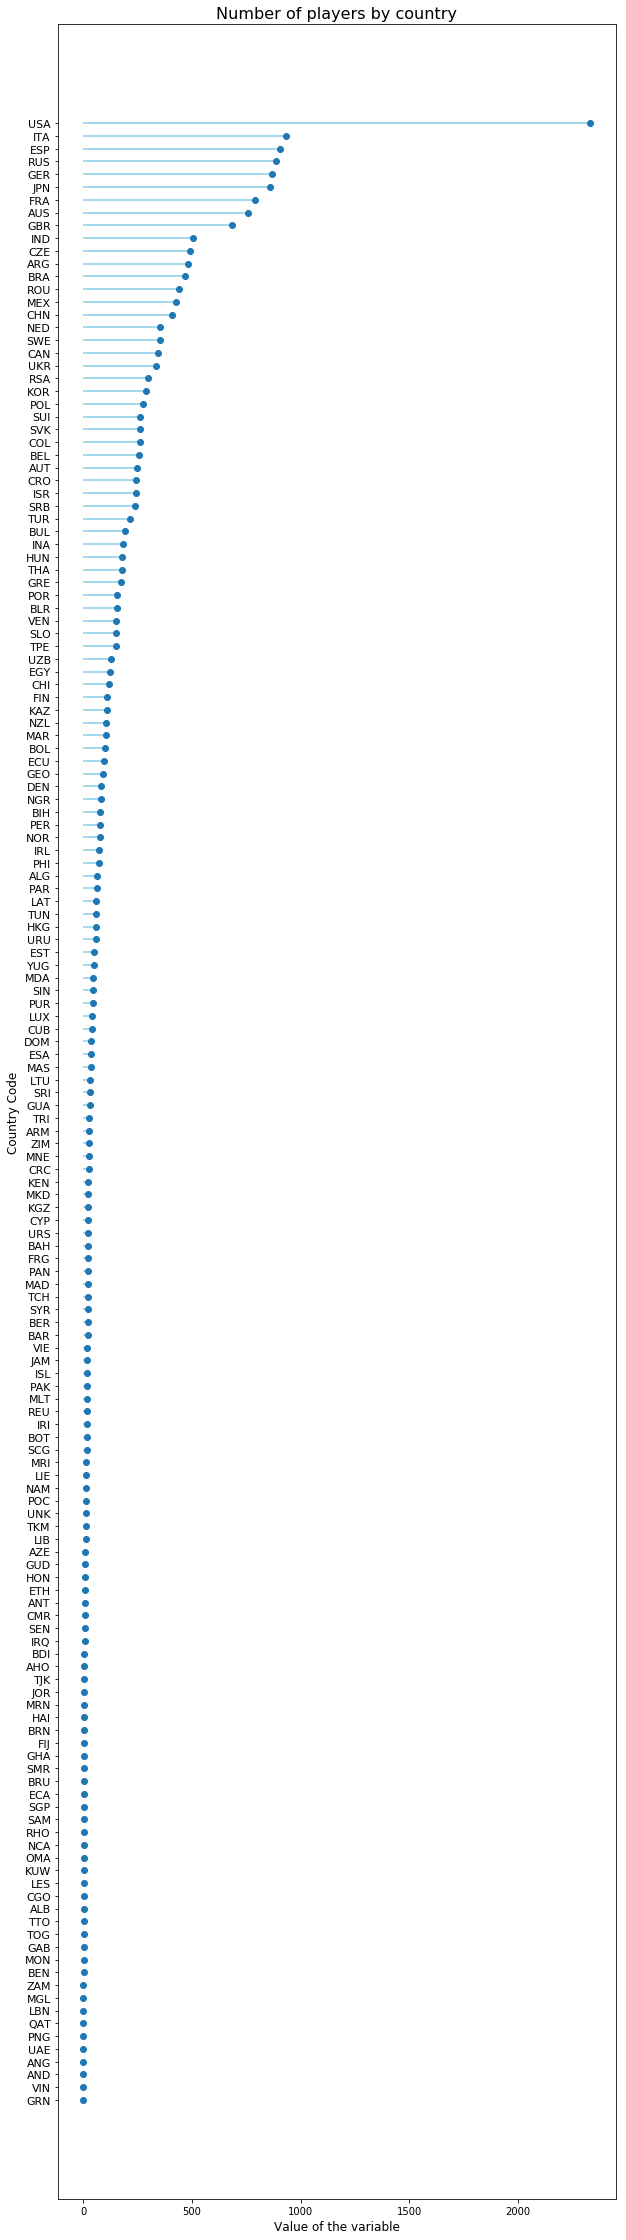

In [35]:
# Show number of players by country with a plot 

# Reorder it following the values:
ordered_df = players_by_country.sort_values(by='total')
my_range=range(1,len(players_by_country.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.figure(figsize=(10,40))
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['total'], color='skyblue', )
plt.plot(ordered_df['total'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['country_code'], fontsize=11)
plt.title("Number of players by country", loc='center', fontsize=16)
plt.xlabel('Value of the variable', fontsize=12)
plt.ylabel('Country Code', fontsize=12)

In [36]:
# Find players in the database by their surname
player_surname = input("Player to find (introduce player's surname): ")
cursor = db.wta_players.find({'last_name': str(player_surname)})

# Apparently there is a bug in the PyMongo cursos class, cause retrieved is set to 0
#   before iterating through the result even if actually there are results from the query.
print('\nApparent results from the query: {0}\n\n'.format(cursor.retrieved))

'''
#print(cursor.retrieved)
#print(cursor.explain())

if cursor.retrieved > 0:
    print('\nThere are: ' + cursor.retrieved + ' results\n')
else:
    print('There are no results for player : ' + player_surname+'\n')
'''

for document in cursor:
    pprint.pprint(document)

Player to find (introduce player's surname): Sanchez

Apparent results from the query: 0


{'_id': ObjectId('5cc797bc539d8bb447a32c79'),
 'birth_date': 19821117,
 'country_code': 'FRA',
 'first_name': 'Olivia',
 'hand': 'U',
 'last_name': 'Sanchez',
 'player_id': 201491}
{'_id': ObjectId('5cc797bd539d8bb447a3345b'),
 'birth_date': 19891126,
 'country_code': 'USA',
 'first_name': 'Maria',
 'hand': 'R',
 'last_name': 'Sanchez',
 'player_id': 202500}
{'_id': ObjectId('5cc797bd539d8bb447a337e5'),
 'birth_date': 19810124,
 'country_code': 'FRA',
 'first_name': 'Laetitia',
 'hand': 'U',
 'last_name': 'Sanchez',
 'player_id': 202953}
{'_id': ObjectId('5cc797bd539d8bb447a34359'),
 'birth_date': 19940413,
 'country_code': 'MEX',
 'first_name': 'Ana Sofia',
 'hand': 'L',
 'last_name': 'Sanchez',
 'player_id': 204419}
{'_id': ObjectId('5cc797bf539d8bb447a35f39'),
 'birth_date': 19860715,
 'country_code': 'COL',
 'first_name': 'Natalia',
 'hand': 'U',
 'last_name': 'Sanchez',
 'player_id': 207987}

In [37]:
print('Real number of results from the query: {0}'.format(cursor.retrieved))

Real number of results from the query: 17


In [38]:
# Find players in the data frame by their surname
player_surname = input("Player to find (introduce player's surname): ")
result = players_df.loc[players_df['last_name'] == player_surname]
result

Player to find (introduce player's surname): Sanchez


,_id,birth_date,country_code,first_name,hand,last_name,player_id
1491,5cc797bc539d8bb447a32c79,19821117,FRA,Olivia,U,Sanchez,201491
2500,5cc797bd539d8bb447a3345b,19891126,USA,Maria,R,Sanchez,202500
2953,5cc797bd539d8bb447a337e5,19810124,FRA,Laetitia,U,Sanchez,202953
4419,5cc797bd539d8bb447a34359,19940413,MEX,Ana Sofia,L,Sanchez,204419
7987,5cc797bf539d8bb447a35f39,19860715,COL,Natalia,U,Sanchez,207987
10104,5cc797c0539d8bb447a36fc5,19910912,COL,Maria Paula,U,Sanchez,210104
10180,5cc797c0539d8bb447a37075,19900223,MEX,Martha,U,Sanchez,210180
10921,5cc797c0539d8bb447a37645,19950409,COL,Ana M,R,Sanchez,210921
10922,5cc797c0539d8bb447a37647,19950915,COL,Paula,U,Sanchez,210922
11457,5cc797c0539d8bb447a37a75,19940405,COL,Arantxa,L,Sanchez,211457


In [39]:
# We get the same results
result.shape

(17, 7)

In [40]:
# Group and count players by use of hand
players_df.groupby('hand').count()

,_id,birth_date,country_code,first_name,last_name,player_id
hand,,,,,,
,954,954,954,954,954,954
L,504,504,504,504,504,504
R,5252,5252,5252,5252,5252,5252
U,15041,15041,15041,15040,15041,15041


In [8]:
# Numbers should be the same for all columns, then just pick up one
players_by_hand = pd.DataFrame()
players_by_hand['total'] = players_df.groupby('hand')['player_id'].count()
players_by_hand

,total
hand,
,954
L,504
R,5252
U,15041


In [42]:
# Total of players
players_df['_id'].count()

21751

In [9]:
# Pie Chart with information about players "strong hand"

#!{sys.executable} -m pip install plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

left_handed = players_by_hand.loc['L','total']
right_handed = players_by_hand.loc['R','total']
undefined = players_by_hand.loc['U','total'] + players_by_hand.loc['','total']
ambidextrous = 0

labels = ['Left Handed','Right Handed','Ambidextrous','Undefined']
values = [left_handed,right_handed,0,undefined]

trace = go.Pie(labels=labels, values=values)
layout = go.Layout(title='Percentage of players by hand')
figure = go.Figure(data=[trace], layout=layout)
po.iplot(figure, filename="players_by_hand_percent_pie_chart")

In [44]:
db.wta_rankings_year.find_one()

{'_id': ObjectId('5cc795c2539d8bb4476cfa6b'),
 'ranking_date': 20180101,
 'ranking': 1,
 'player_id': 201594,
 'ranking_points': 6175,
 'field4': 18,
 'year': '2018'}

In [45]:
rankings_df.head(10)

,_id,field4,player_id,ranking,ranking_date,ranking_points,year
0,5cc795c2539d8bb4476cfa6b,18,201594,1,20180101,6175,2018
1,5cc795c2539d8bb4476cfa6d,21,202469,2,20180101,6135,2018
2,5cc795c2539d8bb4476cfa6f,23,201496,3,20180101,6015,2018
3,5cc795c2539d8bb4476cfa71,20,201662,4,20180101,5730,2018
4,5cc795c2539d8bb4476cfa73,16,200748,5,20180101,5597,2018
5,5cc795c2539d8bb4476cfa75,19,202494,6,20180101,5500,2018
6,5cc795c2539d8bb4476cfa77,21,211533,7,20180101,5010,2018
7,5cc795c2539d8bb4476cfa79,23,201614,8,20180101,4385,2018
8,5cc795c2539d8bb4476cfa7b,20,202427,9,20180101,3610,2018
9,5cc795c2539d8bb4476cfa7d,18,201535,10,20180101,3258,2018


In [46]:
rankings_df[rankings_df['player_id']==200001]

,_id,field4,player_id,ranking,ranking_date,ranking_points,year
59822,5cc795d4539d8bb4476efaa5,,200001,1,20000101,6074,2000
60871,5cc795d4539d8bb4476f02d7,,200001,1,20000103,6074,2000
61928,5cc795d4539d8bb4476f0b19,,200001,1,20000110,6074,2000
62991,5cc795d5539d8bb4476f1368,,200001,1,20000117,6003,2000
64052,5cc795d5539d8bb4476f1bb3,,200001,1,20000124,6003,2000
65113,5cc795d5539d8bb4476f23fd,,200001,1,20000131,5793,2000
66172,5cc795d6539d8bb4476f2c43,,200001,1,20000207,5734,2000
67232,5cc795d6539d8bb4476f348b,,200001,1,20000214,5734,2000
68295,5cc795d6539d8bb4476f3cd9,,200001,1,20000221,5734,2000
69355,5cc795d6539d8bb4476f4521,,200001,1,20000228,5684,2000


In [11]:
# We will be working with just one ranking per year, the latest of each year.
# Therefore, we order the dataframe by ranking_date and delete duplicates per player and year,
#   that is, per each player and year combination, just keep the most recent
ranking_per_year = rankings_df.sort_values('ranking_date', ascending=False)
ranking_per_year = ranking_per_year.drop_duplicates(subset=['player_id','year'], keep='first')

# Clean data and convert to proper types
filter = ranking_per_year['player_id']!=''
ranking_per_year = ranking_per_year[filter]
ranking_per_year['player_id']=ranking_per_year['player_id'].astype(int)
ranking_per_year.drop(['_id', 'field4'], axis=1, inplace=True)

ranking_per_year.sort_values(['year', 'ranking'], ascending=True).head(20)

,player_id,ranking,ranking_date,ranking_points,year
1598434,200293,1,19841231,,1984
1598435,200259,2,19841231,,1984
1598436,200348,3,19841231,,1984
1598437,200360,4,19841231,,1984
1598438,200209,5,19841231,,1984
1598439,200401,6,19841231,,1984
1598440,200377,7,19841231,,1984
1598441,200354,8,19841231,,1984
1598442,200404,9,19841231,,1984
1598443,200389,10,19841231,,1984


In [12]:
# Convert to proper types and merge ranking data with player data
#   so it's easy to get players name and other information
players_df['player_id']=players_df['player_id'].astype(int)

merged_ranking = pd.merge(ranking_per_year, players_df, left_on='player_id', right_on='player_id', how='left')
merged_ranking.drop('_id', axis=1, inplace=True)

# The following command shouldn't be needed!!
#merged_ranking.drop_duplicates(subset=['player_id','year'], keep='first', inplace=True)

full_ranking = merged_ranking.sort_values(['year', 'ranking'], ascending=True)
full_ranking.head(20)

,player_id,ranking,ranking_date,ranking_points,year,birth_date,country_code,first_name,hand,last_name
42184,200293,1,19841231,,1984,19561018,USA,Martina,L,Navratilova
42188,200259,2,19841231,,1984,19541221,USA,Chris,R,Evert
42189,200348,3,19841231,,1984,19620219,AUS,Hana,R,Mandlikova
42190,200360,4,19841231,,1984,19620704,USA,Pam,R,Shriver
42191,200209,5,19841231,,1984,19521126,AUS,Wendy,U,Turnbull
42192,200401,6,19841231,,1984,19670214,SUI,Manuela,R,Maleeva Fragniere
42193,200377,7,19841231,,1984,19650223,CZE,Helena,R,Sukova
42194,200354,8,19841231,,1984,19631211,GER,Claudia,R,Kohde Kilsch
42195,200404,9,19841231,,1984,19631116,USA,Zina,U,Garrison
42196,200389,10,19841231,,1984,19591203,USA,Kathy,U,Jordan


In [13]:
# Only plot the top ten
top_ten_ranking = merged_ranking[merged_ranking['ranking'] <= 10].sort_values(['year', 'ranking'], ascending=True)
top_ten_ranking.head(10)

,player_id,ranking,ranking_date,ranking_points,year,birth_date,country_code,first_name,hand,last_name
42184,200293,1,19841231,,1984,19561018,USA,Martina,L,Navratilova
42188,200259,2,19841231,,1984,19541221,USA,Chris,R,Evert
42189,200348,3,19841231,,1984,19620219,AUS,Hana,R,Mandlikova
42190,200360,4,19841231,,1984,19620704,USA,Pam,R,Shriver
42191,200209,5,19841231,,1984,19521126,AUS,Wendy,U,Turnbull
42192,200401,6,19841231,,1984,19670214,SUI,Manuela,R,Maleeva Fragniere
42193,200377,7,19841231,,1984,19650223,CZE,Helena,R,Sukova
42194,200354,8,19841231,,1984,19631211,GER,Claudia,R,Kohde Kilsch
42195,200404,9,19841231,,1984,19631116,USA,Zina,U,Garrison
42196,200389,10,19841231,,1984,19591203,USA,Kathy,U,Jordan


In [14]:
# Plot ranking of top ten players per year
# Note: Year 1984 and 1985 don't have ranking points data, so the ranking is just the order bottom-up

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import ipywidgets as widgets
from ipywidgets import interactive

init_notebook_mode(connected=True)

def show_bar_chart(year):
    top_ten = top_ten_ranking[top_ten_ranking['year'] == year].iloc[:10]
    player_names = top_ten['first_name'] + ' ' + top_ten['last_name']
    player_ranking = top_ten['ranking_points']

    data = [go.Bar(
                x=player_ranking,
                y=player_names,
                orientation = 'h'
    )]
    
    layout = go.Layout(
        title='Player ranking by year: ' + year,
        xaxis=dict(title='ranking points'),
        yaxis=go.layout.YAxis(
            automargin=True,

        )
    )

    figure = go.Figure(data=data, layout=layout)
    po.iplot(figure, filename='ranking_per_year_horitzontal_bar')
    

# List to select year
items = sorted(top_ten_ranking['year'].unique().tolist(), reverse=True)

# Interactively show bar chart depending on the selected year
def view(year='2018'):
    show_bar_chart(str(year))
 
w = widgets.Select(options=items)
interactive(view, year=w)

interactive(children=(Select(description='year', options=('2018', '2017', '2016', '2015', '2014', '2013', '201…